# Load Data

In [6]:
#Load Libraries
from sklearn.datasets import load_files
from keras.utils import np_utils
import numpy as np
from glob import glob
import ntpath

In [3]:
#Function to load files
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']),133)
    return dog_files,dog_targets

In [4]:
#load files
train_files , train_targets = load_dataset('/Users/bhartisharma/Documents/DeepLearning/DogBreed---Classification/Udacity_data/dogImages/train')
valid_files, valid_targets = load_dataset('/Users/bhartisharma/Documents/DeepLearning/DogBreed---Classification/Udacity_data/dogImages/valid')
test_files,test_targets = load_dataset('/Users/bhartisharma/Documents/DeepLearning/DogBreed---Classification/Udacity_data/dogImages/test')

In [198]:
#Extracting Dog Breed names
dog_names = [item[20:-1] for item in sorted(glob('/Users/bhartisharma/Documents/DeepLearning/DogBreed---Classification/Udacity_data/dogImages/train/*/'))]

dog_breeds = []
for i in range(0,len(dog_names)):
    dog_breeds.append(ntpath.basename(dog_names[i]))

In [199]:
dog_breeds[2]

'003.Airedale_terrier'

In [58]:
print("Total Dog Categories:%d"%len(dog_names))

Total Dog Categories:133


# Data Preprocessing

In [65]:
from keras.preprocessing import image
#add progress bars to Python code is with tqdm. 
from tqdm import tqdm

In [82]:
def path_to_tensor(img_path):
     # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path,target_size=(224,224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3) by using img_to_array
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor by using expand_dims
    return np.expand_dims(x,axis=0)
    
def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

#vstack is vertical stack array

In [83]:
#load trucated images or incomplete images by using LOAD_TRUNCATED_IMAGES 
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True  

In [84]:
# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 836/836 [00:08<00:00, 95.74it/s] 


# Create a CNN to Classify Dog Breeds

In [105]:
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import GlobalAveragePooling2D
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.normalization import BatchNormalization

In [109]:
model = Sequential()

model.add(Conv2D(16,(3,3),padding = 'same',input_shape=(224,224,3)))
#BatchNormalization: Normalize the activations of the previous layer at each batch, i.e. applies a transformation
#that maintains the mean activation close to 0 and the activation standard deviation close to 1.
model.add(BatchNormalization(axis=3,scale = False))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(4,4),strides=(4,4),padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv2D(32,(3,3),padding = 'same'))
model.add(BatchNormalization(axis=3 ,scale= False))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(4,4),strides = (4,4),padding='same'))
model.add(Dropout(0.2))

model.add(Conv2D(64,(3,3),padding = 'same'))
model.add(BatchNormalization(axis=3 ,scale= False))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(4,4),strides = (4,4),padding='same'))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3, 3), padding='same', use_bias=False))
model.add(BatchNormalization(axis=3, scale=False))
model.add(Activation("relu"))
model.add(Flatten())
model.add(Dropout(0.2))

model.add(Dense(512, activation='relu'))
model.add(Dense(133,activation = 'softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_34 (Conv2D)           (None, 224, 224, 16)      448       
_________________________________________________________________
batch_normalization_32 (Batc (None, 224, 224, 16)      48        
_________________________________________________________________
activation_28 (Activation)   (None, 224, 224, 16)      0         
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 56, 56, 16)        0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 56, 56, 16)        0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 56, 56, 32)        4640      
_________________________________________________________________
batch_normalization_33 (Batc (None, 56, 56, 32)        96        
__________

In [115]:
from keras.callbacks import ModelCheckpoint 

In [116]:
#The RMSprop optimizer is similar to the gradient descent algorithm with momentum. The RMSprop optimizer restricts
#the oscillations in the vertical direction. Therefore, we can increase our learning rate and 
#our algorithm could take larger steps in the horizontal direction converging faster.

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [117]:
checkpointer = ModelCheckpoint(filepath='/Users/bhartisharma/Documents/DeepLearning/DogBreed---Classification/Udacity_data/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

In [118]:
model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=10, batch_size=32, callbacks=[checkpointer], verbose=1)


Train on 6680 samples, validate on 835 samples
Epoch 1/10
6680/6680 [==============================] - 1147s 172ms/step - loss: 4.4481 - acc: 0.0419 - val_loss: 4.3268 - val_acc: 0.0467

Epoch 00001: val_loss improved from inf to 4.32676, saving model to /Users/bhartisharma/Documents/DeepLearning/DogBreed---Classification/Udacity_data/weights.best.from_scratch.hdf5
Epoch 2/10
6680/6680 [==============================] - 442s 66ms/step - loss: 4.1863 - acc: 0.0672 - val_loss: 4.1976 - val_acc: 0.0527

Epoch 00002: val_loss improved from 4.32676 to 4.19765, saving model to /Users/bhartisharma/Documents/DeepLearning/DogBreed---Classification/Udacity_data/weights.best.from_scratch.hdf5
Epoch 3/10
6680/6680 [==============================] - 439s 66ms/step - loss: 3.9974 - acc: 0.0864 - val_loss: 4.4640 - val_acc: 0.0491

Epoch 00003: val_loss did not improve from 4.19765
Epoch 4/10
6680/6680 [==============================] - 490s 73ms/step - loss: 3.8505 - acc: 0.0997 - val_loss: 4.5696 -

In [131]:
model.load_weights('/Users/bhartisharma/Documents/DeepLearning/DogBreed---Classification/Udacity_data/weights.best.from_scratch.hdf5')
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor,axis=0))) for tensor in test_tensors]
# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 9.3301%


117.Pekingese


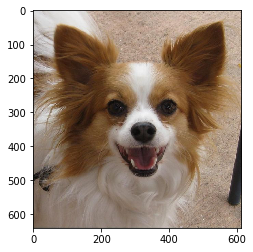

In [213]:
import matplotlib.image as mpimg 
import matplotlib.pyplot as plt 
# Read Images 
#Input 'test' for Testing for breeds
test = 2


img = mpimg.imread(test_files[test]) 
# Output Images 
plt.imshow(img) 
i = dog_breed_predictions[test]
print(dog_breeds[i-1])

In [212]:
#Desired Prediction
ntpath.basename(test_files[19])

'Cairn_terrier_02965.jpg'